# Experiments
Having implemented the different networks and models we can now run them and analyse the results of different parameterisations. This is meant as an exploratory analysis of the effects of different parameters. For the web app we will simualate the models with parameters on a finer grid.

In [1]:
%matplotlib inline

# allow relative imports
import os
import sys

module = os.path.abspath(os.path.join('..'))
if module not in sys.path:
    sys.path.append(module)
    

# utils
from functools import partial
import numpy as np
import pickle
import matplotlib.pyplot as plt

# reproducibility
SEED = 4401

The following Human Contact Networks will be compared:
- Mobility network
- Power law with cutoff
- Physical distancing network

For each, we will evaluate the following epidemic models:
- SEIR
- SEIVR
- SEIR with quarantine
- SEVIR with quarantine

Each model will require slightly different parameters.

## Networks

For each of the three types of networks we will create two instances: a baseline network representing nodes living under no restrictions/distancing etc. (we will call this __pre__) and a network assuming some form of physical distancing put in place (called __post__). We can then plug in each of these networks into the different models.

The mobility networks have `10000` nodes and average node degrees of `4` and `3` for __pre__ and __post__ respectively. Where appropriate, we will mimick these characteristics in the other networks for comparability reasons.

### Mobility network

The mobility networks are based on mobility data from SafeGraph for New Haven County, CT, USA. The __pre__ network is adapted from data from February 2020, before stay-at-home orders were issued, while the __post__ network is based on data from April 2020, after such orders were put in place in March.

The graphs for the two networks have already been producen (see *network_creation.ipynb*), so we can use the `MNGeneratorFromFile`. For now, it suffices defining the parameters of the generator, which we can then pass to the experiment later on.

In [2]:
from data_processing.data_paths import GRAPHS
from model.network.mobility_network import MNGeneratorFromFile as MNGF

In [3]:
params_mobility_pre = dict()
params_mobility_pre[MNGF.N] = 10000
params_mobility_pre[MNGF.EXPONENT] = 2
params_mobility_pre[MNGF.CUTOFF] = 40
params_mobility_pre[MNGF.PATH] = os.path.join(GRAPHS, 'pre_N_10000_E_2_C_40.graphml')

params_mobility_post = dict()
params_mobility_post[MNGF.N] = 10000
params_mobility_post[MNGF.EXPONENT] = 2
params_mobility_post[MNGF.CUTOFF] = 40
params_mobility_post[MNGF.PATH] = os.path.join(GRAPHS, 'post_N_10000_E_2_C_40.graphml')

### Power law with cutoff

The power law with cutoff (PLC) creates a network with nodes with degrees that follow a power law distribution but have a cutoff point at the upper end to prevent implausibly high degrees. `epydemic` provides a NetworkGenerator for this type of network so we can create it from there. The cutoff parameter is set to `10`. Again, we only define the parameters now and pass them to the experiment with the generator later.

In [4]:
from epydemic import PLCNetwork

In [5]:
params_plc_pre = dict()
params_plc_pre[PLCNetwork.N] = 10000
params_plc_pre[PLCNetwork.EXPONENT] = 2
params_plc_pre[PLCNetwork.CUTOFF] = 40

params_plc_post = dict()
params_plc_post[PLCNetwork.N] = 10000
params_plc_post[PLCNetwork.EXPONENT] = 2
params_plc_post[PLCNetwork.CUTOFF] = 40

### Physical distancing

In [6]:
from model.network.distanced_network import DNGenerator as DNG
from model.distributions import household_size_dist, intra_household_contacts, node_degree_dist

In [7]:
average_family = partial(household_size_dist, mu=4.5, std=2)
intra_family_contacts = partial(intra_household_contacts, std=1)
inter_family_contacts = node_degree_dist

params_distanced_pre = dict()
params_distanced_pre[DNG.N] = 10000
params_distanced_pre[DNG.CLUSTER_SIZE_DIST] = average_family
params_distanced_pre[DNG.CONTACT_DIST] = intra_family_contacts
params_distanced_pre[DNG.CLUSTER_CONTACT_DIST] = partial(inter_family_contacts, exponent=4)
params_distanced_pre[DNG.SEED] = SEED

params_distanced_post = dict()
params_distanced_post[DNG.N] = 10000
params_distanced_post[DNG.CLUSTER_SIZE_DIST] = average_family
params_distanced_post[DNG.CONTACT_DIST] = intra_family_contacts
params_distanced_post[DNG.CLUSTER_CONTACT_DIST] = partial(inter_family_contacts, exponent=3)
params_distanced_post[DNG.SEED] = SEED

## Epidemic model

### SEIR

In [8]:
from epydemic import SEIR
from model.compartmental_models.seir import MonitoredSEIR

In [9]:
seir_compartments = {
    SEIR.SUSCEPTIBLE: 'susceptible',
    SEIR.EXPOSED: 'exposed',
    SEIR.INFECTED: 'infected',
    SEIR.REMOVED: 'removed'
}

### SEIR with quarantine

In [10]:
from model.compartmental_model.seir import SEIRWithQuarantine as SEIRQ
from model.compartmental_model.seir import MonitoredSEIRWithQuarantine as MonitoredSEIRQ

### SEIVR

In [11]:
from model.compartmental_model.seivr import SEIVR
from model.compartmental_model.seivr import MonitoredSEIVR

In [12]:
seivr_compartments = {
    SEIVR.SUSCEPTIBLE: 'susceptible',
    SEIVR.EXPOSED: 'exposed',
    SEIVR.INFECTED: 'infected',
    SEIVR.VACCINATED: 'vaccinated',
    SEIVR.REMOVED: 'removed'
}

### SEIVR with quarantine

In [13]:
from model.compartmental_model.seivr import SEIVRWithQuarantine as SEIVRQ
from model.compartmental_model.seivr import MonitoredSEIVRWithQuarantine as MonitoredSEIVRQ

## Parameters

We will fix as many COVID-19 specific parameters as we can and leave only policy dependent parameters open for modifications.

We set the following parameters

| Variable | Value | Description | Reference |
| :-- | --: | :-- | :-- |
| R0 | $2.85$ | Basic Reproduction Number | 1) |
| P_INFECT | ... | P. of infection | ... |
| P_REMOVE | $0.01$ | P. of removal | 2) |
| P_SYMPTOPMS | $0.2$ | P. of becoming symptomatic | 3) |
| P_EXPOSED | $0.01$ | P. of initial infection | ... |
| RRR | $0.95$, $0.67$ | Vaccine efficacy | 4), 5), 6) |
| P_VACCINATED | $10^{-3}$ to $10^{-2}$ by $10^{-3}$| P. of getting vaccinated | ... |
| P_VACCINATED_INITIAL | $0$ to $1$ by $0.1$ | P. of initial vaccination | ... |
| P_QUARANTINE | $0$ to $1$ by $0.1$ | P. of rewiring | ... |


1) https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0249271

2) https://www.thelancet.com/journals/lanmic/article/PIIS2666-5247(20)30172-5/fulltext

3) https://doi.org/10.3389/fpubh.2020.598547

4) https://www.nejm.org/doi/full/10.1056/NEJMoa2034577

5) https://www.nejm.org/doi/full/10.1056/nejmoa2035389

6) https://www.sciencedirect.com/science/article/pii/S0140673620326611

In [14]:
# Fixed
R0 = 2.85
_P_INFECT = None  # to calculate later 
P_REMOVE = 0.01
P_SYMPTOMS = 0.2
P_EXPOSED = 0.01

_RRR = [0.95, 0.67]

# Free
_P_VACCINATED = np.arange(0.001, 0.011, 0.001)
_P_VACCINATED_INITAL = np.arange(0, 1.1, 0.1)
_P_QUARANTINE = np.arange(0, 1.1, 0.1)

Note that we assume `P_EXPOSED` to be fixed. The reason for this is that the model is mostly invariant towards this value; changing it (for the most part) just moves the values horizontally. We denote parameters that need to be further realised/calculated for the actual model by prefixing them with an underscore `_`. `P_INFECT_S` can be calculated from knowing `R0`, `P_REMOVE`, as well as the mean and variance of the node degree distribution of the network (See [Dobson 2020](!https://pyepydemic.readthedocs.io/en/latest/cookbook/from-r-to-probabilities.html)).

In [15]:
def calc_p_infect(r0, p_remove, k_mean, k_var):
    """
    Calc p_infect.
    :param r0: basic reproduction number
    :param p_remove: probability of removal
    :param k_mean: Mean of node degree distribution
    :param k_var: Variance of node degree distribution
    :return: p_infect
    """
    return p_remove * r0 * (k_mean / (k_var - k_mean))

It also appears that asymptomatic cases (i.e. `exposed` compartment) are about 50% as infectious as symptomatic cases (`infected` compartment) (See [McEvoy et al. 2021](!https://bmjopen.bmj.com/content/11/5/e042354)). Hence, when required, we will set `P_INFECT_A` = `P_INFECT_S` $\times \ \frac{1}{2}$.

We can already set the fixed parameters for the models.

In [16]:
params_seir = dict()
params_seir[SEIR.P_SYMPTOMS] = P_SYMPTOMS
params_seir[SEIR.P_REMOVE] = P_REMOVE
params_seir[SEIR.P_EXPOSED] = P_EXPOSED

params_seivr = dict()
params_seivr[SEIVR.P_SYMPTOMS] = P_SYMPTOMS
params_seivr[SEIVR.P_EXPOSED] = P_EXPOSED

## Simulations

We wrap some of the steps required to exectute and collect the results of an experiment in the `ExperimentRunner` class. We also require the epydemic `StochasticDynamics` and `Monitor`.

In [17]:
from experiments.runner import ExperimentRunner
from epydemic import StochasticDynamics, Monitor

# define the monitor parameters
params_monitor = dict()
params_monitor[Monitor.DELTA] = 10

### SEIR on MobilityNetwork

For each type of network we must first calculate the network-specific `P_INFECT`. In the case of mobility networks we can get the mean and variance of the power law cutoff distribution with the same parameters as that used for the node distribution of the network.

In [18]:
from model.distributions import PowerLawCutoffDist as PLCD

tau = params_mobility_pre[MNGF.EXPONENT]
kappa = params_mobility_pre[MNGF.CUTOFF]
plcd = PLCD(tau, kappa)

P_INFECT_MOBILITY = calc_p_infect(R0, P_REMOVE, plcd.mean, plcd.var)

Having collected all parameters, we can now run the experiment using the `ExperimentRunner`.

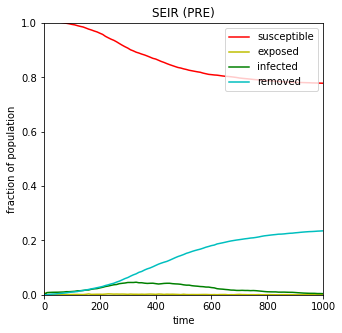

In [24]:
# define the process
e = StochasticDynamics(MonitoredSEIR(), g=MNGF())

# merge all parameters
params = params_mobility_pre | params_seir | params_monitor
params[SEIR.P_INFECT_SYMPTOMATIC] = P_INFECT_MOBILITY
params[SEIR.P_INFECT_ASYMPTOMATIC] = P_INFECT_MOBILITY / 2

er = ExperimentRunner(e, params[MNGF.N])
er.run(params, T=1000)
del params

er.plot('SEIR (PRE)', seir_compartments)

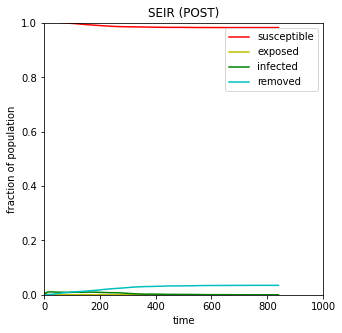

In [25]:
# merge all parameters
params = params_mobility_post | params_seir | params_monitor
params[SEIR.P_INFECT_SYMPTOMATIC] = P_INFECT_MOBILITY
params[SEIR.P_INFECT_ASYMPTOMATIC] = P_INFECT_MOBILITY / 2

er2 = ExperimentRunner(e, params[MNGF.N])
er2.run(params, T=1000)
del params

er2.plot('SEIR (POST)', seir_compartments)